In [1]:
from comet_ml.api import API
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import entropy
from sympy.ntheory import factorint
from sympy.utilities.iterables import multiset_partitions
from pathlib import Path

comet_api = API(api_key="hRTMB66l59BMb9pPrRzLrbzwp")
experiments = comet_api.get(workspace="tensorized-rnn", project_name="row-mnist")

def fetch_val_eer(experiments, cores_result_dict):
    for exp in experiments:
        tags = exp.get_tags()
        tag = tags[-1]
        
        if tag in cores_result_dict.keys():
            # best validation eer is the last one recorded.
            best_val_eer_dict = exp.get_metrics("best_eer")[-1]
            best_val_eer = float(best_val_eer_dict['metricValue'])
            # best_val_eer_step = int(best_val_eer_dict['step'])
            
            cores_result_dict[tag].append(best_val_eer)
    print(cores_result_dict)
    
    # average results of experiment repeats.
    cores_avg_result_dict = {}
    for tag, eer_list in cores_result_dict.items():
        print("Tag: {}. No of experiments: {}".format(tag, len(eer_list)))
        cores_avg_result_dict[tag] = round(np.mean(eer_list) * 100, 2) 
        
    return cores_avg_result_dict


def safely_get_parameter(api_exp, param_name):
    param_list = api_exp.get_parameters_summary(param_name)
    if len(param_list) == 0:
        raise ValueError("parameter '{}' was not found in experiment '{}'"
                         .format(param_name, api_exp.get_metadata()["experimentKey"]))
    return param_list["valueCurrent"]

###----------FUNCTIONS from t3nsor library for getting auto shape of a tensor-train cores--------####
def _get_all_factors(n, d=3, mode='ascending'):
    p = _factorint2(n)
    if len(p) < d:
        p = p + [1, ] * (d - len(p))

    if mode == 'ascending':
        def prepr(x):
            return tuple(sorted([np.prod(_) for _ in x]))
    elif mode == 'descending':
        def prepr(x):
            return tuple(sorted([np.prod(_) for _ in x], reverse=True))

    elif mode == 'mixed':
        def prepr(x):
            x = sorted(np.prod(_) for _ in x)
            N = len(x)
            xf, xl = x[:N//2], x[N//2:]
            return tuple(_roundrobin(xf, xl))

    else:
        raise ValueError('Wrong mode specified, only {} are available'.format(MODES))

    raw_factors = multiset_partitions(p, d)
    clean_factors = [prepr(f) for f in raw_factors]
    clean_factors = list(set(clean_factors))
    return clean_factors

def _to_list(p):
    res = []
    for k, v in p.items():
        res += [k, ] * v
    return res

def _factorint2(p):
    return _to_list(factorint(p))

def auto_shape(n, d=3, criterion='entropy', mode='ascending'):
    factors = _get_all_factors(n, d=d, mode=mode)
    if criterion == 'entropy':
        weights = [entropy(f) for f in factors]
    elif criterion == 'var':
        weights = [-np.var(f) for f in factors]
    else:
        raise ValueError('Wrong criterion specified, only {} are available'.format(CRITERIONS))

    i = np.argmax(weights)
    return list(factors[i])
###----------FUNCTIONS from t3nsor library for getting auto shape of a tensor-train cores--------####

def lstm_num_params(num_layers, hidden_size, input_size, bias=True, n_gates_and_cell=4):
    result = 0
    
    # layer 1
    result = n_gates_and_cell * ((input_size + hidden_size + int(bias)) * hidden_size)
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        result += num_layers_minus_1 * n_gates_and_cell * ((hidden_size + hidden_size + int(bias)) * hidden_size)
    
    return result

def tt_linear_num_params(in_size, out_size, n_cores, rank, bias=True):
    if in_size == 0 or out_size == 0:
        return 0
    in_core_shape = auto_shape(in_size, n_cores)
    out_core_shape = auto_shape(out_size, n_cores)
    
    # number of parameters in a tt linear layer.
    assert len(in_core_shape) == len(out_core_shape)
    n_cores = len(in_core_shape)
    
    result = 0
    out_size = 1
    for i in range(n_cores):
        if i == 0 or i == n_cores - 1:
            result += rank * (in_core_shape[i]) * out_core_shape[i]
        else:
            result += rank**2 * (in_core_shape[i]) * out_core_shape[i]
        out_size *= out_core_shape[i]
    
    if bias:
        result += out_size
    
#     print('linear output ', result)
    return result

def tt_lstm_num_params_with_concattrick(num_layers, in_size, hidden_size, n_cores, rank, bias=True, n_gates_and_cell=4):
    # number of parameters in a tt lstm that uses concatenation trick.
    result = 0
    
    # layer 1
    result = (tt_linear_num_params(in_size, hidden_size * n_gates_and_cell, n_cores, rank, False) 
                      + tt_linear_num_params(hidden_size, hidden_size * n_gates_and_cell, n_cores, rank, bias))
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        result += num_layers_minus_1 * (tt_linear_num_params(hidden_size, hidden_size * n_gates_and_cell, n_cores, rank, False) 
                      + tt_linear_num_params(hidden_size, hidden_size * n_gates_and_cell, n_cores, rank, bias))
    
    return result

# Model size and parameter count

In [2]:
hidden_sizes = [256, 512, 768]
num_layers = [1, 2, 3]
input_size = 28
emb_size = 0  # note not counting non-tensorized layers for mnist.
n_gates = 4

data = []
for hidden_size in hidden_sizes:
    row = []
    for layer_size in num_layers:
        num_linear_layer = ((hidden_size + 1) * emb_size)
        num_lstm_layers = lstm_num_params(layer_size, hidden_size, input_size, n_gates_and_cell=n_gates)
        row.append(num_lstm_layers + num_linear_layer)
    data.append(row)
result = pd.DataFrame(data, index=hidden_sizes, columns=num_layers)
print("No of parameters")
print(result)

No of parameters
           1        2         3
256   291840   817152   1342464
512  1107968  3207168   5306368
768  2448384  7170048  11891712


# Parameters in tensorized models (by rank and cores)

In [24]:
input_size = 28
emb_size = 10
n_cores_list = [2,3,4]
ranks_list = [1, 2, 4, 5, 6, 7, 8, 10]
n_gates = 4

def print_tt_lstm_options(num_layers, hidden_size, input_size, emb_size, n_cores_list, ranks_list):
    data = []
    for i in range(len(n_cores_list)):
        n_cores = n_cores_list[i]
        row = []
        for rank in ranks_list:
            num_lstm_layers = tt_lstm_num_params_with_concattrick(num_layers, input_size, hidden_size, 
                                                          n_cores, rank, bias=True, n_gates_and_cell=n_gates)
#             num_linear_layer = ((hidden_size + 1) * emb_size) # linear layer was not compressed.
            num_linear_layer = tt_linear_num_params(hidden_size, hidden_size, n_cores, rank, bias=True)
            num_output_layer = tt_linear_num_params(hidden_size, emb_size, n_cores, rank, bias=True)
            row.append(num_lstm_layers + num_linear_layer + num_output_layer)
        data.append(row)
    data = pd.DataFrame(data, index=n_cores_list, columns=ranks_list)
    return data

#---------------
hidden_size = 256
num_layers = 1
print("No of parameters ({}/{})".format(num_layers, hidden_size))
print(print_tt_lstm_options(num_layers, hidden_size, input_size, emb_size, n_cores_list, ranks_list))
print("")

No of parameters (1/256)
122
234
458
570
682
794
906
1130
70
162
442
630
850
1102
1386
2050
46
106
298
430
586
766
970
1450
     1     2     4      5      6      7      8      10
2  3290  5290  9290  11290  13290  15290  17290  21290
3  1862  2754  5498   7350   9522  12014  14826  21410
4  1570  2082  3802   5010   6450   8122  10026  14530



# Parameters in tensorized models (by rank and hidden size)

In [10]:
input_size = 28
emb_size = 0
hidden_size_list = [256, 512, 1024, 2048, 4096]
ranks_list = [1, 2, 4, 5, 6, 8, 10]
n_gates = 4

def print_tt_lstm_options(num_layers, hidden_size_list, input_size, emb_size, n_cores, ranks_list):
    data = []
    for i in range(len(hidden_size_list)):
        hidden_size = hidden_size_list[i]
        row = []
        for rank in ranks_list:
            num_lstm_layers = tt_lstm_num_params_with_concattrick(num_layers, input_size, hidden_size, 
                                                          n_cores, rank, bias=True, n_gates_and_cell=n_gates)
            num_linear_layer = ((hidden_size + 1) * emb_size) # linear layer was not compressed.
            row.append(num_lstm_layers + num_linear_layer)
        data.append(row)
    data = pd.DataFrame(data, index=hidden_size_list, columns=ranks_list)
    return data

#---------------
n_cores = 2
num_layers = 1
print("No of parameters (nlayers{}/ncores{})".format(num_layers, n_cores))
print(print_tt_lstm_options(num_layers, hidden_size_list, input_size, emb_size, n_cores, ranks_list))
print("")

#---------------
n_cores = 3
num_layers = 1
print("No of parameters (nlayers{}/ncores{})".format(num_layers, n_cores))
print(print_tt_lstm_options(num_layers, hidden_size_list, input_size, emb_size, n_cores, ranks_list))
print("")

#---------------
n_cores = 4
num_layers = 1
print("No of parameters (nlayers{}/ncores{})".format(num_layers, n_cores))
print(print_tt_lstm_options(num_layers, hidden_size_list, input_size, emb_size, n_cores, ranks_list))
print("")

No of parameters (nlayers1/ncores2)
         1      2      4       5       6       8       10
256    2400   3776   6528    7904    9280   12032   14784
512    5184   8320  14592   17728   20864   27136   33408
1024   8896  13696  23296   28096   32896   42496   52096
2048  19584  30976  53760   65152   76544   99328  122112
4096  34176  51968  87552  105344  123136  158720  194304

No of parameters (nlayers1/ncores3)
         1      2      4      5      6      8      10
256    1392   1920   3456   4464   5632   8448  11904
512    2528   3328   5888   7648   9728  14848  21248
1024   4784   5792   8768  10736  13024  18560  25376
2048   9376  11136  16384  19872  23936  33792  45952
4096  17984  20736  29696  35904  43264  61440  84224

No of parameters (nlayers1/ncores4)
         1      2      4      5      6      8      10
256    1204   1528   2608   3364   4264   6496   9304
512    2284   2712   4144   5148   6344   9312  13048
1024   4384   4928   6784   8096   9664  13568  18496
20

# Results

Skipping experiment: use_tt=false, n_cores=1, tt_rank=1
Skipping experiment: use_tt=false, n_cores=1, tt_rank=1
TT-2cores params: [2464, 3904, 6784, 9664, 12544, 15424]
TT-3cores params: [1376, 1920, 3584, 6016, 9216, 13184]
TT-4cores params: [1192, 1504, 2560, 4192, 6400, 9184]


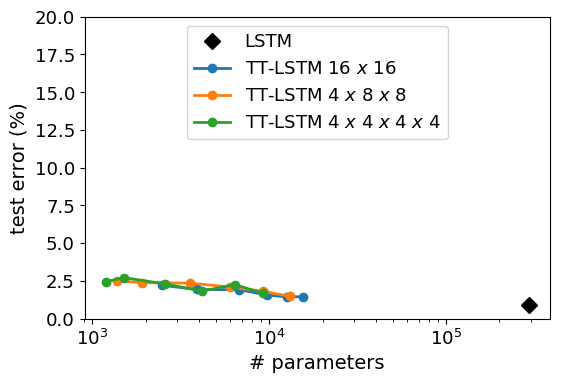

In [12]:
def create_dict_with_tt_results():
    """ Load test accuracies according to ranks and no of cores """
    
    # dict with "key: n-cores", "value: dict of (key: rank, value: test_eer)"
    experiments_result_dict = {2: {1: 0, 2: 0, 4: 0, 6: 0, 8:0, 10:0},
                              3: {1: 0, 2: 0, 4: 0, 6: 0, 8:0, 10:0},
                              4: {1: 0, 2: 0, 4: 0, 6: 0, 8:0, 10:0}}

    for exp in experiments:    
        use_tt = exp.get_parameters_summary("tt")["valueCurrent"]
        if not use_tt: continue

        try:
            n_cores = int(safely_get_parameter(exp, "ncores"))
            tt_rank = int(safely_get_parameter(exp, "ttrank"))
            best_test_acc = float(exp.get_metrics("best_test_acc")[-1]['metricValue'])
        except Exception as e:
            print(e)
            continue

        if n_cores not in experiments_result_dict \
                or tt_rank not in experiments_result_dict[n_cores]:
            print("Skipping experiment: use_tt={}, n_cores={}, tt_rank={}".format(use_tt, n_cores, tt_rank))
            continue
        experiments_result_dict[n_cores][tt_rank] = best_test_acc
    return experiments_result_dict
experiments_result_dict = create_dict_with_tt_results()

plt.figure(dpi=100)
input_size = 40
emb_size = 0
hidden_size = 256
num_layers = 1

# plot uncompressed experiment.
plt.plot(291840, 100 - 99.07, "D", label="LSTM", color='black', markersize=8)

# plot tt experiments.
for k, v in experiments_result_dict.items():
    param_counts = []
    for rank in v.keys():
        num_lstm_layers = tt_lstm_num_params_with_concattrick(num_layers, input_size, hidden_size, k, rank, bias=True)
        num_linear_layer = tt_linear_num_params(hidden_size, emb_size, k, rank, bias=True)
    
        param_counts.append(num_lstm_layers + num_linear_layer)
    print("TT-{}cores params: {}".format(k, param_counts))
    
    # plot all rank values for the current core, k.
    shape_str = " $x$ ".join([str(s) for s in auto_shape(hidden_size, k)])
    values_as_err = [100 - val for val in v.values()]
    plt.plot(param_counts, values_as_err, "-o", label="TT-LSTM " + shape_str, linewidth=2, markersize=6)
plt.xscale('log')
# plt.yscale('semilog')
plt.xlabel('# parameters', fontsize=14)
plt.ylabel('test error (%)', fontsize=14)
plt.ylim([0,20])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13, loc='upper center')
plt.show()

###### experiments_result_dict = create_dict_with_results()
print(experiments_result_dict)

In [13]:
20416 - 17344

3072